<a href="https://colab.research.google.com/github/miguelruor/GeneticEvolution/blob/main/GeneticEvolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here we model genetic evolution via two models: continuous-time random walks and quantum walks  (Venegas-Andraca 2012), both over a given genotype space (Wagner, 2011). This work is an extension of Santiago et al. 2021. 

We compute hitting times to novel phenotypes in both models in every simulation.

# Libraries

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import expm
from scipy.sparse import csr_matrix
from scipy.linalg import norm
from scipy.sparse.linalg import expm_multiply
from scipy.stats import expon
import pandas as pd
import json
import uuid

In [ ]:
from pathlib import Path

# Function to read all name files in a folder
def ls(ruta = Path.cwd()): 
    return [arch.name for arch in Path(ruta).iterdir() if arch.is_file()]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importation of graphs

In [ ]:
dir_file_2phen = "/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_2phen/genotype_space/gspace.gml"
dir_file_4phen = "/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/genotype_space/gspace.gml"

In [ ]:
gspace_2phen = nx.read_gml(dir_file_2phen, label='id')
gspace_4phen = nx.read_gml(dir_file_4phen, label='id')

# Identifying genotype networks

### Maximum number of steps to find a novel phenotype

In [ ]:
gspace_2phen.nodes[0].keys()

dict_keys(['label', 'sequence', 'phenotypeName', 'phenotypeIndex', 'node_novelPhen', 'steps_novelPhen', 'nodes_novelPhen'])

In [ ]:
gspace_2phen.nodes[0]['steps_novelPhen']

1

In [ ]:
maxSteps = 0

for v in gspace_4phen.nodes:
  if gspace_4phen.nodes[v]['steps_novelPhen'] != 'infinity' and gspace_4phen.nodes[v]['steps_novelPhen'] > maxSteps:
    maxSteps = gspace_4phen.nodes[v]['steps_novelPhen']
  
maxSteps

5

In [ ]:
maxSteps_2 = 0

for v in gspace_2phen.nodes:
  if gspace_2phen.nodes[v]['steps_novelPhen'] != 'infinity' and gspace_2phen.nodes[v]['steps_novelPhen'] > maxSteps_2:
    maxSteps_2 = gspace_2phen.nodes[v]['steps_novelPhen']
  
maxSteps_2

8

Genotypes at n steps away from a novel phenotype, n=1,2,3,..., maxSteps (four phenotype graph)

In [ ]:
vertex_nSteps = {}
for n in range(1, maxSteps+1):
  vertex_nSteps[n] = []
vertex_nSteps['infinity'] = []

for v in gspace_4phen.nodes:
  vertex_nSteps[gspace_4phen.nodes[v]['steps_novelPhen']].append(v)

In [ ]:
for i in vertex_nSteps:
  print("Nodos a", i, "pasos de encontrar un nuevo fenotipo: ", len(vertex_nSteps[i]))

Nodos a 1 pasos de encontrar un nuevo fenotipo:  254
Nodos a 2 pasos de encontrar un nuevo fenotipo:  205
Nodos a 3 pasos de encontrar un nuevo fenotipo:  99
Nodos a 4 pasos de encontrar un nuevo fenotipo:  18
Nodos a 5 pasos de encontrar un nuevo fenotipo:  3
Nodos a infinity pasos de encontrar un nuevo fenotipo:  0


Genotypes at n steps away from a novel phenotype, n=1,2,3,..., maxSteps (two phenotype graph)

In [ ]:
vertex_nSteps_2 = {}
for n in range(1, maxSteps_2+1):
  vertex_nSteps_2[n] = []
vertex_nSteps_2['infinity'] = []

for v in gspace_2phen.nodes:
  vertex_nSteps_2[gspace_2phen.nodes[v]['steps_novelPhen']].append(v)

In [ ]:
for i in vertex_nSteps_2:
  print("Nodos a", i, "pasos de encontrar un nuevo fenotipo: ", len(vertex_nSteps_2[i]))

Nodos a 1 pasos de encontrar un nuevo fenotipo:  87
Nodos a 2 pasos de encontrar un nuevo fenotipo:  136
Nodos a 3 pasos de encontrar un nuevo fenotipo:  114
Nodos a 4 pasos de encontrar un nuevo fenotipo:  36
Nodos a 5 pasos de encontrar un nuevo fenotipo:  12
Nodos a 6 pasos de encontrar un nuevo fenotipo:  6
Nodos a 7 pasos de encontrar un nuevo fenotipo:  4
Nodos a 8 pasos de encontrar un nuevo fenotipo:  1
Nodos a infinity pasos de encontrar un nuevo fenotipo:  0


### Identifying genotype networks

In [ ]:
phenIndex_4phen = {'Ascl2': 0, 'Bbx': 1, 'Foxa2': 2, 'Mafb': 3}
phenIndex_2phen = {'Bbx': 0, 'Foxa2': 1}

In [ ]:
genotype_networks_4phen = {'Ascl2': {}, 'Bbx': {}, 
                           'Foxa2': {}, 'Mafb': {}}
genotype_networks_2phen = {'Bbx': {}, 'Foxa2': {}}

In [ ]:
for phen in phenIndex_4phen:
  genotype_networks_4phen[phen]['phenotype'] = phen
  genotype_networks_4phen[phen]['phenotype_id'] = phenIndex_4phen[phen]
  genotype_networks_4phen[phen]['nodes'] = []
  genotype_networks_4phen[phen]['total_nodes'] = 0

for phen in phenIndex_2phen:
  genotype_networks_2phen[phen]['phenotype'] = phen
  genotype_networks_2phen[phen]['phenotype_id'] = phenIndex_2phen[phen]
  genotype_networks_2phen[phen]['nodes'] = []
  genotype_networks_2phen[phen]['total_nodes'] = 0

In [ ]:
for v in gspace_4phen.nodes:
  for phen in gspace_4phen.nodes[v]['phenotypeName']:
    genotype_networks_4phen[phen]['nodes'].append(v)
    genotype_networks_4phen[phen]['total_nodes'] += 1

for v in gspace_2phen.nodes:
  for phen in gspace_2phen.nodes[v]['phenotypeName']:
    genotype_networks_2phen[phen]['nodes'].append(v)
    genotype_networks_2phen[phen]['total_nodes'] += 1

In [ ]:
print(genotype_networks_2phen['Foxa2']['total_nodes'])
print(genotype_networks_2phen['Bbx']['total_nodes'])
print(len(gspace_2phen.nodes))
print(len(set(genotype_networks_2phen['Foxa2']['nodes']).intersection(set(genotype_networks_2phen['Bbx']['nodes']))))

325
71
396
0


In [ ]:
print(genotype_networks_4phen['Mafb']['total_nodes'])
print(genotype_networks_4phen['Ascl2']['total_nodes'])
print(genotype_networks_4phen['Foxa2']['total_nodes'])
print(genotype_networks_4phen['Bbx']['total_nodes'])
print(len(gspace_4phen.nodes))

112
76
328
74
579


In [ ]:
genotype_networks_4phen['Mafb'].keys()

dict_keys(['phenotype', 'phenotype_id', 'nodes', 'total_nodes'])

In [ ]:
gspace_4phen.nodes[0].keys()

dict_keys(['label', 'sequence', 'phenotypeName', 'phenotypeIndex', 'node_novelPhen', 'steps_novelPhen', 'nodes_novelPhen'])

In [ ]:
for phen in phenIndex_4phen:
  for n in vertex_nSteps:
    vertex_nSteps_phen = set(vertex_nSteps[n]).intersection(set(genotype_networks_4phen[phen]['nodes']))
    print("Nodes in genotype network of", phen, "at", n, "steps from novel phenotype:", len(vertex_nSteps_phen))

Nodes in genotype network of Ascl2 at 1 steps from novel phenotype: 4
Nodes in genotype network of Ascl2 at 2 steps from novel phenotype: 19
Nodes in genotype network of Ascl2 at 3 steps from novel phenotype: 36
Nodes in genotype network of Ascl2 at 4 steps from novel phenotype: 15
Nodes in genotype network of Ascl2 at 5 steps from novel phenotype: 2
Nodes in genotype network of Ascl2 at infinity steps from novel phenotype: 0
Nodes in genotype network of Bbx at 1 steps from novel phenotype: 38
Nodes in genotype network of Bbx at 2 steps from novel phenotype: 27
Nodes in genotype network of Bbx at 3 steps from novel phenotype: 8
Nodes in genotype network of Bbx at 4 steps from novel phenotype: 1
Nodes in genotype network of Bbx at 5 steps from novel phenotype: 0
Nodes in genotype network of Bbx at infinity steps from novel phenotype: 0
Nodes in genotype network of Foxa2 at 1 steps from novel phenotype: 147
Nodes in genotype network of Foxa2 at 2 steps from novel phenotype: 131
Nodes in 

In [ ]:
for phen in phenIndex_2phen:
  for n in vertex_nSteps_2:
    vertex_nSteps_phen = set(vertex_nSteps_2[n]).intersection(set(genotype_networks_2phen[phen]['nodes']))
    print("Nodes in genotype network of", phen, "at", n, "steps from novel phenotype:", len(vertex_nSteps_phen))

Nodes in genotype network of Bbx at 1 steps from novel phenotype: 37
Nodes in genotype network of Bbx at 2 steps from novel phenotype: 25
Nodes in genotype network of Bbx at 3 steps from novel phenotype: 8
Nodes in genotype network of Bbx at 4 steps from novel phenotype: 1
Nodes in genotype network of Bbx at 5 steps from novel phenotype: 0
Nodes in genotype network of Bbx at 6 steps from novel phenotype: 0
Nodes in genotype network of Bbx at 7 steps from novel phenotype: 0
Nodes in genotype network of Bbx at 8 steps from novel phenotype: 0
Nodes in genotype network of Bbx at infinity steps from novel phenotype: 0
Nodes in genotype network of Foxa2 at 1 steps from novel phenotype: 50
Nodes in genotype network of Foxa2 at 2 steps from novel phenotype: 111
Nodes in genotype network of Foxa2 at 3 steps from novel phenotype: 106
Nodes in genotype network of Foxa2 at 4 steps from novel phenotype: 35
Nodes in genotype network of Foxa2 at 5 steps from novel phenotype: 12
Nodes in genotype netw

In [ ]:
for v in genotype_networks_4phen['Ascl2']['nodes']:
  if gspace_4phen.nodes[v]['sequence'] == 'CAGCTGAC':
    print(v)

10


In [ ]:
for v in genotype_networks_4phen['Mafb']['nodes']:
  if gspace_4phen.nodes[v]['sequence'] == 'CTGCTGAC':
    print(v)

542


In [ ]:
phenotypes = genotype_networks_4phen.keys()

# Auxiliar functions

In [ ]:
np.random.seed(2021)

In [ ]:
def randomInitialGenotype(gspace):
  return np.random.choice(gspace.nodes)

# function that returns a random genotype in a genotype network
def randomInitialGenotypeFromGenotypeNetwork(genotype_network):
  return np.random.choice(genotype_network['nodes'])

# function that returns a random genotype in a genotype network at n steps of finding a novel phenotype
def randomInitialGenotypeNSteps(genotype_network, n):
  return np.random.choice(list(set(vertex_nSteps[n]).intersection(set(genotype_network['nodes'])))) 

def randomPhenotype(phenotypes):
  return np.random.choice(phenotypes)

# index of the sequence given
def sequenceIndex(sequence, gspace):
  for v in gspace.nodes:
    if sequence == gspace.nodes[v]['sequence']:
      return v

Function to obtain the distance between two DNA sequences

In [ ]:
def distance(sequence1, sequence2):
  dist = 0
  N = len(sequence1)

  for i in range(N):
    if sequence1[i] != sequence2[i]:
      dist += 1

  return dist

# Quantum genetic evolution (CTQW)

### Auxiliar functions

Function to obtain the Hamiltonian associated to a given graph and the mutation rate

In [ ]:
def giveMeHamiltonian(G, gamma, typeMatrix="laplacian"):
  # typeMatrix could be "adjacency" to use the adjacency matrix based Hamiltoninan 
  # or "laplacian" (default) to use the Laplacian matrix based Hamiltonian
  # gamma is the mutation rate 

  if typeMatrix == "adjacency":
    A = nx.adjacency_matrix(G)
  else:
    A = nx.laplacian_matrix(G)

  H = -gamma* A

  return H

Function to calculate the i-th canonical vector in $C^n$

In [ ]:
def canonical_vector(i, n):
  # i-esimo vector canonico en C^n
  ei = np.zeros(n)
  ei[i] = 1.0
  return ei

Function to simulate a measurement of the quantum walk

In [ ]:
def measurement(state, basis):
  # state is a vector in C^N

  qprobs = [abs(state[v])**2 for v in basis]
  collapse = np.random.choice(basis, p=qprobs)

  return collapse

In [ ]:
state = [(0.5)**(0.5), (0.5j)**(0.5)]
basis = [0, 1]
print(measurement(state, basis))

1


### Reading last results



In [ ]:
#parameters = pd.DataFrame(columns=['initial_phen', 'initial_gen', 'initial_gen_index', 'max_measurements', 'measurement_rate', 'transition_rate'])

In [ ]:
#estimations_results = pd.DataFrame(columns=['tau_Ascl2_prom (seconds)', 'tau_Ascl2_prom (days)', 'N_Ascl2_prom', 
#                  'tau_Bbx_prom (seconds)', 'tau_Bbx_prom (days)', 'N_Bbx_prom', 'tau_Mafb_prom (seconds)', 
#                  'tau_Mafb_prom (days)', 'N_Mafb_prom', 'tau_Foxa2_prom (seconds)', 'tau_Foxa2_prom (days)', 'N_Foxa2_prom'])

#simulations_results = pd.DataFrame(columns =['parameters_index', 'tau_Ascl2', "tau_Bbx", "tau_Foxa2", "tau_Mafb", 'N_Ascl2', 
#                  "N_Bbx", "N_Foxa2", "N_Mafb"])

In [ ]:
parameters = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/QW_parameters.csv", index_col=0)
simulations_results = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/QW_simulations_results.csv", index_col=0)
estimations_results = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/QW_estimation_results.csv", index_col=0)

In [ ]:
simulations_results

,parameters_index,tau_Ascl2,tau_Bbx,tau_Foxa2,tau_Mafb,N_Ascl2,N_Bbx,N_Foxa2,N_Mafb
0,0.0,-1.000000,-1.000000,48201.618690,0.000000,-1.0,-1.0,983.0,0.0
1,0.0,-1.000000,131112.550087,23713.601659,0.000000,-1.0,2621.0,445.0,0.0
2,0.0,-1.000000,201750.675204,3703.249948,0.000000,-1.0,4041.0,69.0,0.0
3,0.0,-1.000000,141926.249905,22674.404962,0.000000,-1.0,2769.0,437.0,0.0
4,0.0,-1.000000,164332.314996,25337.977626,0.000000,-1.0,3349.0,504.0,0.0
...,...,...,...,...,...,...,...,...,...
196,81.0,0.000000,243693.624261,243146.910956,232750.934378,0.0,4860.0,4849.0,4658.0
197,82.0,-1.000000,105173.301284,0.000000,2440.516368,-1.0,2059.0,0.0,54.0
198,83.0,206848.934784,-1.000000,0.000000,141660.516225,4161.0,-1.0,0.0,2882.0
199,84.0,-1.000000,-1.000000,204233.061299,0.000000,-1.0,-1.0,4117.0,0.0


In [ ]:
estimations_results

,tau_Ascl2_prom (seconds),tau_Ascl2_prom (days),N_Ascl2_prom,tau_Bbx_prom (seconds),tau_Bbx_prom (days),N_Bbx_prom,tau_Mafb_prom (seconds),tau_Mafb_prom (days),N_Mafb_prom,tau_Foxa2_prom (seconds),tau_Foxa2_prom (days),N_Foxa2_prom


In [ ]:
parameters

,initial_phen,initial_gen,initial_gen_index,max_measurements,measurement_rate,transition_rate
0,Mafb,ATGAAAAA,552,5000,50,0.0010
1,Ascl2,CAGCTGCG,57,5000,50,0.0001
2,Bbx,TTATGAAA,128,5000,50,0.0001
3,Ascl2,ACAGCTGT,44,5000,50,0.0001
4,Mafb,ATTTGCAA,575,5000,50,0.0001
...,...,...,...,...,...,...
81,Ascl2,CATATGCC,56,5000,50,0.0010
82,Foxa2,AAACAACA,253,5000,50,0.0010
83,Foxa2,ATTGTTTA,252,5000,50,0.0010
84,Mafb,GAATTTGC,490,5000,50,0.0010


## Simulation algorithm

In [ ]:
def simulation_qw(simulations, gspace, phenotypes, url_evolution_paths, url_simulations_results):
  global simulations_results
  
  if new_parameters:
    parameters_index = len(parameters)-1

  tau = {} # estimation of tau (hitting time) for every phenotype 
  # Time it takes quantum walk to find given phenotype

  N = {} # estimation of N 
  # number of jumps the random walk takes to find a genotype with a new phenotype

  phenotype_frequency = {} # for saving phenotype frequency in evolution path
  evolution_path_columns = ["holding time", "accumulated time", "genotype index", "genotype sequence"]

  for phen in phenotypes:
    evolution_path_columns.append(phen + " freq.")

  for i in range(simulations):
    print('Start of simulation', i+1, '/', simulations)

    no_measurement = 0
    time = 0

    #initialization
    for phen in phenotypes:
      tau[phen] = -1
      N[phen] = -1

    evolution_path = pd.DataFrame(columns=evolution_path_columns) # indices of genotypes of the evolution 
    actual_state = initial_genotype 

    evolution_path_aux = {}
    # phenotypes of actual state
    phenotypes_actual_state = gspace.nodes[actual_state]['phenotypeName']
    # the other phenotypes in genotype space
    phenotypes_actual_state_complement = set(phenotypes).difference(set(phenotypes_actual_state))

    for phen in phenotypes_actual_state:
      evolution_path_aux[phen+" freq."] = 1.0

    for phen in phenotypes_actual_state_complement:
      evolution_path_aux[phen+" freq."] = 0.0

    evolution_path_aux['holding time'] = 0.0
    evolution_path_aux['accumulated time'] = 0.0
    evolution_path_aux['genotype index'] = int(initial_genotype)
    evolution_path_aux['genotype sequence'] = gspace.nodes[initial_genotype]['sequence']

    evolution_path = evolution_path.append(evolution_path_aux, ignore_index=True)

    while no_measurement < max_measurements:
      for phen in phenotypes_actual_state:
        if tau[phen] < 0: # update hitting times of novel phenotypes
          tau[phen] = time
          N[phen] = no_measurement
        
      T = expon.rvs(scale=measurement_rate, size=1)[0] # sample of exponential distribution with scale parameter measurement_rate

      evolution_path_aux['holding time'] = T
      evolution_path_aux['accumulated time'] = T+time
      
      # evolving quantum walk
      actual_state_vec = canonical_vector(actual_state, M) # vector representing genotype actual_state
      actual_state_vec = expm_multiply(-1j*T*H, actual_state_vec) # evolve quantum walk until time T with actual_state as initial state
      actual_state = measurement(actual_state_vec, gspace.nodes)

      evolution_path_aux['genotype index'] = actual_state
      evolution_path_aux['genotype sequence'] = gspace.nodes[actual_state]['sequence']

      # phenotypes of actual state
      phenotypes_actual_state = gspace.nodes[actual_state]['phenotypeName']
      # the other phenotypes in genotype space
      phenotypes_actual_state_complement = set(phenotypes).difference(set(phenotypes_actual_state))

      for phen in phenotypes_actual_state:
        evolution_path_aux[phen+" freq."] = (evolution_path[phen+" freq."][no_measurement]*no_measurement+1)/(no_measurement+1)

      for phen in phenotypes_actual_state_complement:
        evolution_path_aux[phen+" freq."] = (evolution_path[phen+" freq."][no_measurement]*no_measurement)/(no_measurement+1)

      evolution_path = evolution_path.append(evolution_path_aux, ignore_index=True)

      time += T
      no_measurement += 1
      
      if no_measurement % 1000 == 0:
        print("Measurement number", no_measurement)
        print("Accumulated time", time)
    
    print("End of simulation", i+1)
      
    simulations_results_aux = {'parameters_index': int(parameters_index)}

    for phen in phenotypes:
      simulations_results_aux['tau_'+phen] = tau[phen]
      simulations_results_aux['N_'+phen] = N[phen]

    simulations_results = simulations_results.append(simulations_results_aux, ignore_index=True)
    
    evolution_path.to_csv(url_evolution_paths+str(len(simulations_results)-1)+".csv")
    
  # writing results of simulations  
  simulations_results.to_csv(url_simulations_results)

## Simulations

Function to perform simulations with random initial genotypes

In [ ]:
def randomSimulations_QW(simulations, gspace, phenotypes, url_parameters, url_evolution_paths, url_simulations_results):
  global parameters
  global initial_genotype
  global initial_sequence
  global initial_phen

  for i in range(simulations):
    print("Start of random simulation", i+1,"/",simulations)
    initial_genotype = randomInitialGenotype(gspace)
    initial_sequence = gspace.nodes[initial_genotype]['sequence']
    initial_phen = gspace.nodes[initial_genotype]['phenotypeName'][0]

    parameters = parameters.append({'initial_phen': initial_phen, 'initial_gen': initial_sequence, 'initial_gen_index': initial_genotype, 
                                'max_measurements': max_measurements, 'measurement_rate': measurement_rate, 'transition_rate': gamma}, 
                               ignore_index=True)
    parameters.to_csv(url_parameters)

    simulation_qw(1, gspace, phenotypes, url_evolution_paths, url_simulations_results)

### Parameters

In [ ]:
simulations = 40 # number of simulations
url_evolution_paths = "/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/evolution_paths_QW/"
url_simulations_results = "/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/QW_simulations_results.csv"
url_parameters = "/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/QW_parameters.csv"
np.random.seed(2021)

#### Old parameters

In [ ]:
parameters

,initial_phen,initial_gen,initial_gen_index,max_measurements,measurement_rate,transition_rate
0,Mafb,ATGAAAAA,552,5000,50,0.001


In [ ]:
parameters_index = 0

In [ ]:
new_parameters = False
max_measurements = parameters.loc[parameters_index]['max_measurements'] # maximum number of measurements in a simulation
measurement_rate = parameters.loc[parameters_index]['measurement_rate'] # This is equal to the average decoherence time of the system. 
# McFadden and Al-Khalili (1999) estimated that it is between 1-100 seconds or more
gamma = parameters.loc[parameters_index]['transition_rate'] # transition rate between neighbor nodes
initial_phen = parameters.loc[parameters_index]['initial_phen']
initial_genotype = parameters.loc[parameters_index]['initial_gen_index']
print(initial_genotype)
print(gspace_4phen.nodes[initial_genotype]['phenotypeName'])

552
['Mafb']


#### New parameters

Required parameters

In [ ]:
new_parameters = True
max_measurements = 5000 # maximum number of measurements in a simulation
measurement_rate = 50 # This is equal to the average decoherence time of the system. 
# McFadden and Al-Khalili (1999) estimated that it is between 1-100 seconds or more
gamma = 10**(-3) # transition rate between neighbor nodes

Optional parameters </br>

You can choose simulations with random initial genotypes with randomSimulations_QW. If this is the case, do not run this cell

In [ ]:
initial_phen = 'Ascl2'
initial_genotype = randomInitialGenotype(initial_phen)
initial_sequence = gspace_4phen.nodes[initial_genotype]['sequence']

# Uncomment the following lines if you want to choose a genotype by its sequence. initial_phen must have its phenotype
# initial sequence = "AAAAAAAA"
# initial_genotype = sequenceIndex(initial_sequence)

print(initial_genotype)
print(gspace_4phen.nodes[initial_genotype]['phenotypeName'])

parameters = parameters.append({'initial_phen': initial_phen, 'initial_gen': initial_sequence, 'initial_gen_index': initial_genotype, 
                                'max_measurements': max_measurements, 'measurement_rate': measurement_rate, 'transition_rate': gamma}, 
                               ignore_index=True)
parameters.to_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/QW_parameters.csv")

#### Loading fix parameters

In [ ]:
H = giveMeHamiltonian(gspace_4phen, gamma)
M = gspace_4phen.number_of_nodes() # number of nodes and dimension of Hilbert space

### Simulations

Simulations with random initial genotype

In [ ]:
randomSimulations_QW(simulations, gspace_4phen, genotype_networks_4phen.keys(), url_parameters, url_evolution_paths, 
                  url_simulations_results)
simulations_results

Start of random simulation 1 / 40
Start of simulation 1 / 1
Measurement number 1000
Accumulated time 50889.90299183145
Measurement number 2000
Accumulated time 99068.61723214865
Measurement number 3000
Accumulated time 149167.01274698897
Measurement number 4000
Accumulated time 201754.45927868193
Measurement number 5000
Accumulated time 250969.16880835991
End of simulation 1
Start of random simulation 2 / 40
Start of simulation 1 / 1
Measurement number 1000
Accumulated time 50813.41427564849
Measurement number 2000
Accumulated time 99459.37860703382
Measurement number 3000
Accumulated time 149501.77290876894
Measurement number 4000
Accumulated time 201265.86772415796
Measurement number 5000
Accumulated time 249111.8008894351
End of simulation 1
Start of random simulation 3 / 40
Start of simulation 1 / 1
Measurement number 1000
Accumulated time 51627.509501007524
Measurement number 2000
Accumulated time 102679.87181254869
Measurement number 3000
Accumulated time 149820.84146311096
Measu

,parameters_index,tau_Ascl2,tau_Bbx,tau_Foxa2,tau_Mafb,N_Ascl2,N_Bbx,N_Foxa2,N_Mafb
0,0.0,-1.000000,-1.000000,48201.618690,0.000000,-1.0,-1.0,983.0,0.0
1,0.0,-1.000000,131112.550087,23713.601659,0.000000,-1.0,2621.0,445.0,0.0
2,0.0,-1.000000,201750.675204,3703.249948,0.000000,-1.0,4041.0,69.0,0.0
3,0.0,-1.000000,141926.249905,22674.404962,0.000000,-1.0,2769.0,437.0,0.0
4,0.0,-1.000000,164332.314996,25337.977626,0.000000,-1.0,3349.0,504.0,0.0
...,...,...,...,...,...,...,...,...,...
196,81.0,0.000000,243693.624261,243146.910956,232750.934378,0.0,4860.0,4849.0,4658.0
197,82.0,-1.000000,105173.301284,0.000000,2440.516368,-1.0,2059.0,0.0,54.0
198,83.0,206848.934784,-1.000000,0.000000,141660.516225,4161.0,-1.0,0.0,2882.0
199,84.0,-1.000000,-1.000000,204233.061299,0.000000,-1.0,-1.0,4117.0,0.0


In [ ]:
parameters

,initial_phen,initial_gen,initial_gen_index,max_measurements,measurement_rate,transition_rate
0,Mafb,ATGAAAAA,552,5000,50,0.0010
1,Ascl2,CAGCTGCG,57,5000,50,0.0001
2,Bbx,TTATGAAA,128,5000,50,0.0001
3,Ascl2,ACAGCTGT,44,5000,50,0.0001
4,Mafb,ATTTGCAA,575,5000,50,0.0001
5,Foxa2,AAATAAAA,459,5000,50,0.0001
6,Bbx,TTCATGAA,116,5000,50,0.0001
7,Ascl2,CATATGTC,45,5000,50,0.0001
8,Bbx,AAATGAAT,145,5000,50,0.0001
9,Foxa2,TCAACAAA,351,5000,50,0.0001


In [ ]:
simulations_results

,parameters_index,tau_Ascl2,tau_Bbx,tau_Foxa2,tau_Mafb,N_Ascl2,N_Bbx,N_Foxa2,N_Mafb
0,0.0,-1.0,-1.000000,48201.618690,0.0,-1.0,-1.0,983.0,0.0
1,0.0,-1.0,131112.550087,23713.601659,0.0,-1.0,2621.0,445.0,0.0
2,0.0,-1.0,201750.675204,3703.249948,0.0,-1.0,4041.0,69.0,0.0
3,0.0,-1.0,141926.249905,22674.404962,0.0,-1.0,2769.0,437.0,0.0
4,0.0,-1.0,164332.314996,25337.977626,0.0,-1.0,3349.0,504.0,0.0
...,...,...,...,...,...,...,...,...,...
156,41.0,0.0,-1.000000,-1.000000,-1.0,0.0,-1.0,-1.0,-1.0
157,42.0,-1.0,-1.000000,0.000000,-1.0,-1.0,-1.0,0.0,-1.0
158,43.0,-1.0,-1.000000,0.000000,-1.0,-1.0,-1.0,0.0,-1.0
159,44.0,-1.0,-1.000000,-1.000000,0.0,-1.0,-1.0,-1.0,0.0


## Evolution paths analysis

Read all evolution paths or a given one

In [ ]:
def allEvolutionPaths():
  # return in a dictionary with keys the simulations index and saves the evolution paths
  all_evolution_paths = {}
  files = ls("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/evolution_paths_QW/")

  for file in files:
    all_evolution_paths[int(file[:-4])] = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/"
      +"evolution_paths_QW/"+file, index_col=0)
    
  return all_evolution_paths

def evolutionPath(simulation_index):
  return pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/evolution_paths_QW/"+
                               str(simulation_index)+".csv", index_col=0)

In [ ]:
all_evolution_paths = allEvolutionPaths()

In [ ]:
evolution_path0 = evolutionPath(0)

In [ ]:
all_evolution_paths[0]

,holding time,accumulated time,genotype index,genotype sequence,Ascl2 freq.,Bbx freq.,Foxa2 freq.,Mafb freq.
0,0.000000,0.000000,552,ATGAAAAA,0.0,0.0,0.000000,1.000000
1,4.530709,4.530709,552,ATGAAAAA,0.0,0.0,0.000000,1.000000
2,47.924004,52.454714,552,ATGAAAAA,0.0,0.0,0.000000,1.000000
3,42.701525,95.156238,552,ATGAAAAA,0.0,0.0,0.000000,1.000000
4,30.087254,125.243492,552,ATGAAAAA,0.0,0.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...
4996,88.302397,253137.555930,376,AAATAATT,0.0,0.0,0.605084,0.394916
4997,30.151671,253167.707601,376,AAATAATT,0.0,0.0,0.605163,0.394837
4998,199.753325,253367.460926,376,AAATAATT,0.0,0.0,0.605242,0.394758
4999,76.834697,253444.295623,376,AAATAATT,0.0,0.0,0.605321,0.394679


# Classic evolution (CTRW)

### Auxiliar functions

In [ ]:
def infinitesimalGenerator(G, gamma):
  # gamma is the mutation rate 

  A = nx.laplacian_matrix(G)
  H = -gamma* A

  return H

In [ ]:
def nextState(states, i, Q):
  # choose next state to jump to from the i-th row of the jump process transition matrix
  # states are the set of state of the random walk
  # i is the actual state
  # Q is the infinitesimal generator of the continuous random walk
  probs = [-Q[i, j]/Q[i, i] for j in states]
  probs[i] = 0 

  return np.random.choice(states, p = probs)

### Reading last results



In [ ]:
#parameters_c = pd.DataFrame(columns=['initial_phen', 'initial_gen', 'initial_gen_index', 'max_jumps', 'transition_rate'])

In [ ]:
#estimations_results_c = pd.DataFrame(columns=['tau_Ascl2_prom (seconds)', 'tau_Ascl2_prom (days)', 'N_Ascl2_prom', 
#                  'tau_Bbx_prom (seconds)', 'tau_Bbx_prom (days)', 'N_Bbx_prom', 'tau_Mafb_prom (seconds)', 
#                  'tau_Mafb_prom (days)', 'N_Mafb_prom', 'tau_Foxa2_prom (seconds)', 'tau_Foxa2_prom (days)', 'N_Foxa2_prom'])

#simulations_results_c = pd.DataFrame(columns =['parameters_index', 'tau_Ascl2', "tau_Bbx", "tau_Foxa2", "tau_Mafb", 'N_Ascl2', 
#                  "N_Bbx", "N_Foxa2", "N_Mafb"])

In [ ]:
parameters_c = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/CW_parameters.csv", index_col=0)
simulations_results_c = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/CW_simulations_results.csv", index_col=0)
estimations_results_c = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/CW_estimation_results.csv", index_col=0)

In [ ]:
simulations_results_c

,parameters_index,tau_Ascl2,tau_Bbx,tau_Foxa2,tau_Mafb,N_Ascl2,N_Bbx,N_Foxa2,N_Mafb
0,0.0,84612.090649,6920.023048,321.125575,0.000000,414.0,40.0,2.0,0.0
1,0.0,112969.379860,21036.119062,1938.534737,0.000000,531.0,95.0,7.0,0.0
2,0.0,554207.920083,8726.610003,3903.591836,0.000000,2480.0,39.0,11.0,0.0
3,0.0,16112.915939,30034.068387,68.433303,0.000000,114.0,191.0,2.0,0.0
4,0.0,36429.698176,2132.817535,1440.334812,0.000000,198.0,11.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...
109,70.0,0.000000,34305.069102,34210.381003,33769.407048,0.0,184.0,183.0,179.0
110,71.0,418189.946021,26083.858453,0.000000,661.081366,1972.0,136.0,0.0,6.0
111,72.0,185412.663629,17238.868577,0.000000,3284.495366,906.0,98.0,0.0,21.0
112,73.0,139792.614740,39312.390413,2042.000122,0.000000,491.0,147.0,4.0,0.0


In [ ]:
estimations_results_c

,tau_Ascl2_prom (seconds),tau_Ascl2_prom (days),N_Ascl2_prom,tau_Bbx_prom (seconds),tau_Bbx_prom (days),N_Bbx_prom,tau_Mafb_prom (seconds),tau_Mafb_prom (days),N_Mafb_prom,tau_Foxa2_prom (seconds),tau_Foxa2_prom (days),N_Foxa2_prom


In [ ]:
parameters_c

,initial_phen,initial_gen,initial_gen_index,max_jumps,transition_rate
0,Mafb,ATGAAAAA,552,5000,0.001
1,Bbx,TTCATGAA,116,5000,0.001
2,Ascl2,CATATGTC,45,5000,0.001
3,Bbx,AAATGAAT,145,5000,0.001
4,Foxa2,TCAACAAA,351,5000,0.001
...,...,...,...,...,...
70,Ascl2,CATATGCC,56,5000,0.001
71,Foxa2,AAACAACA,253,5000,0.001
72,Foxa2,ATTGTTTA,252,5000,0.001
73,Mafb,GAATTTGC,490,5000,0.001


## Simulation algorithm

In [ ]:
def simulation_cw(simulations, gspace, phenotypes, url_evolution_paths, url_simulations_results):
  global simulations_results_c

  if new_parameters:
    parameters_index = len(parameters_c)-1

  tau = {} # estimation of tau (hitting time) for every phenotype 
  # Time it takes quantum walk to find given phenotype

  N = {} # estimation of N 
  # number of jumps the random walk takes to find a genotype with a new phenotype

  phenotype_frequency = {} # for saving phenotype frequency in evolution path
  evolution_path_columns = ["holding time", "accumulated time", "genotype index", "genotype sequence"]

  for phen in phenotypes:
    evolution_path_columns.append(phen + " freq.")

  for i in range(simulations):
    print('Start of simulation', i+1, '/', simulations)
    jump = 0
    time = 0
    
    #initialization
    for phen in phenotypes:
      tau[phen] = -1
      N[phen] = -1

    evolution_path = pd.DataFrame(columns=evolution_path_columns) # indices of genotypes of the evolution 
    actual_state = initial_genotype 

    evolution_path_aux = {}
    # phenotypes of actual state
    phenotypes_actual_state = gspace.nodes[actual_state]['phenotypeName']
    # the other phenotypes in genotype space
    phenotypes_actual_state_complement = set(phenotypes).difference(set(phenotypes_actual_state))

    for phen in phenotypes_actual_state:
      evolution_path_aux[phen+" freq."] = 1.0

    for phen in phenotypes_actual_state_complement:
      evolution_path_aux[phen+" freq."] = 0.0

    evolution_path_aux['holding time'] = 0.0
    evolution_path_aux['accumulated time'] = 0.0
    evolution_path_aux['genotype index'] = int(initial_genotype)
    evolution_path_aux['genotype sequence'] = gspace.nodes[initial_genotype]['sequence']

    evolution_path = evolution_path.append(evolution_path_aux, ignore_index=True)

    while jump < max_jumps:
      for phen in phenotypes_actual_state:
        if tau[phen] < 0: # update hitting times of novel phenotypes
          tau[phen] = time
          N[phen] = jump

      T = expon.rvs(scale = -1/H[actual_state, actual_state], size=1)[0] # sample of exponential distribution

      evolution_path_aux['holding time'] = T
      evolution_path_aux['accumulated time'] = T+time

      for phen in phenotypes_actual_state:
        evolution_path_aux[phen+" freq."] = (evolution_path[phen+" freq."][jump]*time+T)/(time+T)

      for phen in phenotypes_actual_state_complement:
        evolution_path_aux[phen+" freq."] = (evolution_path[phen+" freq."][jump]*time)/(time+T)
      
      # choice next random state
      actual_state = nextState(list(gspace.nodes), actual_state, H)
      evolution_path_aux['genotype index'] = actual_state
      evolution_path_aux['genotype sequence'] = gspace.nodes[actual_state]['sequence']

      evolution_path = evolution_path.append(evolution_path_aux, ignore_index=True)

      # phenotypes of actual state
      phenotypes_actual_state = gspace.nodes[actual_state]['phenotypeName']
      # the other phenotypes in genotype space
      phenotypes_actual_state_complement = set(phenotypes).difference(set(phenotypes_actual_state))
      
      time += T
      jump += 1
      
      if jump % 1000 == 0:
        print("Jump number", jump)
        print("Accumulated time", time)
    
    print("End of simulation", i+1)
      
    simulations_results_aux = {'parameters_index': int(parameters_index)}

    for phen in phenotypes:
      simulations_results_aux['tau_'+phen] = tau[phen]
      simulations_results_aux['N_'+phen] = N[phen]


    simulations_results_c = simulations_results_c.append(simulations_results_aux, ignore_index=True)
    evolution_path.to_csv(url_evolution_paths + str(len(simulations_results_c)-1) + ".csv")
    
  # writing results of simulations
  simulations_results_c.to_csv(url_simulations_results)

## Simulations

Function to perform simulations with random initial genotypes

In [ ]:
def randomSimulations_CW(simulations, gspace, phenotypes, url_parameters, url_evolution_paths, url_simulations_results):
  global parameters_c
  global initial_genotype
  global initial_sequence
  global initial_phen
  
  for i in range(simulations):
    print("Start of random simulation", i+1,"/",simulations)
    initial_genotype = randomInitialGenotype(gspace)
    initial_sequence = gspace.nodes[initial_genotype]['sequence']
    initial_phen = gspace.nodes[initial_genotype]['phenotypeName'][0]

    parameters_c = parameters_c.append({'initial_phen': initial_phen, 'initial_gen': initial_sequence, 'initial_gen_index': int(initial_genotype), 
                                'max_jumps': int(max_jumps), 'transition_rate': gamma}, ignore_index=True)
    parameters_c.to_csv(url_parameters)

    simulation_cw(1, gspace, phenotypes, url_evolution_paths, url_simulations_results)

### Parameters

In [ ]:
simulations = 40
url_parameters_c = "/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/CW_parameters.csv"
url_evolution_paths_c = "/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/evolution_paths_CW/"
url_simulations_results_c = "/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/CW_simulations_results.csv"
np.random.seed(2021)

#### Old parameters

In [ ]:
parameters_c

,initial_phen,initial_gen,initial_gen_index,max_jumps,transition_rate
0,Mafb,ATGAAAAA,552,5000,0.001


In [ ]:
parameters_index = 0

In [ ]:
new_parameters = False
max_jumps = parameters_c.loc[parameters_index]['max_jumps'] # maximum number of jumps in a simulation
gamma = parameters_c.loc[parameters_index]['transition_rate'] # transition rate between neighbor nodes
initial_phen = parameters_c.loc[parameters_index]['initial_phen']
initial_genotype = parameters_c.loc[parameters_index]['initial_gen_index']
print(initial_genotype)
print(gspace_4phen.nodes[initial_genotype]['phenotypeName'])

552
['Mafb']


#### New parameters

Required paramaters

In [ ]:
max_jumps = 5000 # maximum number of jumps in a simulation
# McFadden and Al-Khalili (1999) estimated that it is between 1-100 seconds or more
gamma = 10**(-3) # transition rate between neighbor nodes
new_parameters = True

Optional parameters </br>

You can choose simulations with random initial genotypes with randomSimulations_CW. If this is the case, do not run this cell

In [ ]:
initial_phen = 'Ascl2'
initial_genotype =  randomInitialGenotype(initial_phen)
initial_sequence = gspace_4phen.nodes[initial_genotype]['sequence']

# Uncomment the following lines if you want to choose a genotype by its sequence. initial_phen must have its phenotype
#initial_sequence = "ACAAAAAA"
#initial_genotype = sequenceIndex(initial_sequence)

print(initial_genotype)
print(gspace_4phen.nodes[initial_genotype]['phenotypeName'])

parameters_c = parameters_c.append({'initial_phen': initial_phen, 'initial_gen': initial_sequence, 'initial_gen_index': int(initial_genotype), 
                                'max_jumps': int(max_jumps), 'transition_rate': gamma}, ignore_index=True)
parameters_c.to_csv(url_parameters)

57
['Ascl2']


#### Loading fix parameters

In [ ]:
H = infinitesimalGenerator(gspace_4phen, gamma)
M = gspace_4phen.number_of_nodes() # number of nodes and dimension of Hilbert space

### Simulations

Simulations with random initial genotype

In [ ]:
randomSimulations_CW(simulations, gspace_4phen, genotype_networks_4phen.keys(), url_parameters_c, url_evolution_paths_c, 
                  url_simulations_results_c)
simulations_results_c

Start of random simulation 1 / 40
Start of simulation 1 / 1
Jump number 1000
Accumulated time 218787.87726014957
Jump number 2000
Accumulated time 409272.16763184906
Jump number 3000
Accumulated time 627859.2368896442
Jump number 4000
Accumulated time 839512.2920456582
Jump number 5000
Accumulated time 1037102.0940175486
End of simulation 1
Start of random simulation 2 / 40
Start of simulation 1 / 1
Jump number 1000
Accumulated time 217587.386484979
Jump number 2000
Accumulated time 434150.7267023854
Jump number 3000
Accumulated time 654494.4001880832
Jump number 4000
Accumulated time 879920.4083293197
Jump number 5000
Accumulated time 1077763.4592958163
End of simulation 1
Start of random simulation 3 / 40
Start of simulation 1 / 1
Jump number 1000
Accumulated time 205442.2025122215
Jump number 2000
Accumulated time 432872.06748634257
Jump number 3000
Accumulated time 617613.8006982119
Jump number 4000
Accumulated time 827022.5697723608
Jump number 5000
Accumulated time 1067366.738896

,parameters_index,tau_Ascl2,tau_Bbx,tau_Foxa2,tau_Mafb,N_Ascl2,N_Bbx,N_Foxa2,N_Mafb
0,0.0,84612.090649,6920.023048,321.125575,0.000000,414.0,40.0,2.0,0.0
1,0.0,112969.379860,21036.119062,1938.534737,0.000000,531.0,95.0,7.0,0.0
2,0.0,554207.920083,8726.610003,3903.591836,0.000000,2480.0,39.0,11.0,0.0
3,0.0,16112.915939,30034.068387,68.433303,0.000000,114.0,191.0,2.0,0.0
4,0.0,36429.698176,2132.817535,1440.334812,0.000000,198.0,11.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...
109,70.0,0.000000,34305.069102,34210.381003,33769.407048,0.0,184.0,183.0,179.0
110,71.0,418189.946021,26083.858453,0.000000,661.081366,1972.0,136.0,0.0,6.0
111,72.0,185412.663629,17238.868577,0.000000,3284.495366,906.0,98.0,0.0,21.0
112,73.0,139792.614740,39312.390413,2042.000122,0.000000,491.0,147.0,4.0,0.0


In [ ]:
parameters_c

## Evolution paths analysis

Read all evolution paths or a given one

In [ ]:
def allEvolutionPaths_c():
  # return in a dictionary with keys the simulations index and saves the evolution paths
  all_evolution_paths = {}
  files = ls("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/evolution_paths_CW/")

  for file in files:
    all_evolution_paths[int(file[:-4])] = pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/evolution_paths_CW/"+
                               file, index_col=0)
    
  return all_evolution_paths

def evolutionPath_c(simulation_index):
  return pd.read_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/evolution_paths_CW/"+
                               str(simulation_index)+".csv", index_col=0)

In [ ]:
all_evolution_paths_c = allEvolutionPaths_c()

In [ ]:
evolution_path0 = evolutionPath_c(0)

In [ ]:
evolution_path0

,holding time,accumulated time,genotype index,genotype sequence,Ascl2 freq.,Bbx freq.,Foxa2 freq.,Mafb freq.
0,0.000000,0.000000e+00,552,ATGAAAAA,0.000000,0.000000,0.000000,1.000000
1,233.227900,2.332279e+02,541,ATCAAAAA,0.000000,0.000000,0.000000,1.000000
2,87.897674,3.211256e+02,361,ATCAACAA,0.000000,0.000000,0.000000,1.000000
3,455.203550,7.763291e+02,541,ATCAAAAA,0.000000,0.000000,0.586354,1.000000
4,302.488221,1.078817e+03,534,AGCAAAAA,0.000000,0.000000,0.421947,1.000000
...,...,...,...,...,...,...,...,...
4996,186.700068,1.033957e+06,432,TAAACAAA,0.238517,0.134206,0.491358,0.150560
4997,22.317687,1.033979e+06,267,TACACAAA,0.238512,0.134204,0.491369,0.150557
4998,67.974826,1.034047e+06,177,TACATAAA,0.238497,0.134195,0.491403,0.150547
4999,38.987886,1.034086e+06,418,TAAATAAA,0.238488,0.134190,0.491422,0.150541


# Comparison of both models

## Estimations (deprecated)

In [ ]:
def updateEstimation(parameters_index):
  estimations_results['tau_prom (seconds)'][index] =  simulations_results[simulations_results['parameters_index'] == index]['tau'].mean()
  estimations_results['tau_prom (days)'][index] = estimations_results['tau_prom (seconds)'][index]/(60*24)
  # 60*24 is the number of seconds in a day
  estimations_results['N_prom'][index] = simulations_results[simulations_results['parameters_index'] == index]['N'].mean()

def updateAllEstimations():
  estimations_results = pd.DataFrame(columns=['tau_prom (seconds)', 'tau_prom (days)', 'N_prom'])

  for index, row in parameters.iterrows():
    estimation_result_aux = {}
    estimation_result_aux['tau_prom (seconds)'] =  simulations_results[simulations_results['parameters_index'] == index]['tau'].mean()
    estimation_result_aux['tau_prom (days)'] = estimation_result_aux['tau_prom (seconds)']/(60*24)
    # 60*24 is the number of seconds in a day
    estimation_result_aux['N_prom'] = simulations_results[simulations_results['parameters_index'] == index]['N'].mean()


    estimations_results = estimations_results.append(estimation_result_aux, ignore_index=True)

  return estimations_results


In [ ]:
estimations_results = updateAllEstimations()

In [ ]:
estimations_results

,tau_prom (seconds),tau_prom (days),N_prom
0,4.635340e+05,321.898631,5854.000000
1,1.401699e+06,973.401744,17517.752381
2,9.499409e+05,659.681194,11872.990000
3,3.784746e+06,2628.295600,25212.690000
4,4.990389e+05,346.554792,49896.210000
5,1.000163e+05,69.455766,100000.000000
6,1.026799e+04,7.130547,1000.000000
7,8.269004e+04,57.423636,1648.400000
8,2.481227e+05,172.307409,5000.000000
9,2.115363e+05,146.900222,4214.400000


In [ ]:
estimations_results.to_csv("/content/drive/My Drive/Thesis/Code/newData/paperBased/gspace_4phen/CTQW_estimation_results.csv")

## Comparing

In [ ]:
parameters

,initial_phen,initial_gen,initial_gen_index,max_measurements,measurement_rate,transition_rate
0,Mafb,ATGAAAAA,552,5000,50,0.0010
1,Ascl2,CAGCTGCG,57,5000,50,0.0001
2,Bbx,TTATGAAA,128,5000,50,0.0001
3,Ascl2,ACAGCTGT,44,5000,50,0.0001
4,Mafb,ATTTGCAA,575,5000,50,0.0001
...,...,...,...,...,...,...
81,Ascl2,CATATGCC,56,5000,50,0.0010
82,Foxa2,AAACAACA,253,5000,50,0.0010
83,Foxa2,ATTGTTTA,252,5000,50,0.0010
84,Mafb,GAATTTGC,490,5000,50,0.0010


In [ ]:
parameters_c

,initial_phen,initial_gen,initial_gen_index,max_jumps,transition_rate
0,Mafb,ATGAAAAA,552,5000,0.001
1,Bbx,TTCATGAA,116,5000,0.001
2,Ascl2,CATATGTC,45,5000,0.001
3,Bbx,AAATGAAT,145,5000,0.001
4,Foxa2,TCAACAAA,351,5000,0.001
...,...,...,...,...,...
70,Ascl2,CATATGCC,56,5000,0.001
71,Foxa2,AAACAACA,253,5000,0.001
72,Foxa2,ATTGTTTA,252,5000,0.001
73,Mafb,GAATTTGC,490,5000,0.001


In [ ]:
simulations_results.tail(40)

,parameters_index,tau_Ascl2,tau_Bbx,tau_Foxa2,tau_Mafb,N_Ascl2,N_Bbx,N_Foxa2,N_Mafb
161,46.0,-1.000000,0.000000,13246.160090,14651.859537,-1.0,0.0,268.0,292.0
162,47.0,0.000000,-1.000000,-1.000000,-1.000000,0.0,-1.0,-1.0,-1.0
163,48.0,-1.000000,0.000000,4377.438339,25159.888530,-1.0,0.0,81.0,480.0
164,49.0,-1.000000,40145.341633,0.000000,1977.348612,-1.0,781.0,0.0,33.0
165,50.0,-1.000000,0.000000,606.132786,46661.486696,-1.0,0.0,9.0,964.0
166,51.0,201841.540304,0.000000,3537.271531,2486.109119,4026.0,0.0,67.0,42.0
167,52.0,0.000000,-1.000000,-1.000000,-1.000000,0.0,-1.0,-1.0,-1.0
168,53.0,-1.000000,11582.665324,0.000000,99316.219663,-1.0,223.0,0.0,1996.0
169,54.0,-1.000000,-1.000000,0.000000,48954.478266,-1.0,-1.0,0.0,975.0
170,55.0,-1.000000,31156.352184,0.000000,16911.059778,-1.0,611.0,0.0,322.0


In [ ]:
simulations_results_c.tail(40)

,parameters_index,tau_Ascl2,tau_Bbx,tau_Foxa2,tau_Mafb,N_Ascl2,N_Bbx,N_Foxa2,N_Mafb
74,35.0,52649.291390,0.000000,968.387644,1970.938087,234.0,0.0,2.0,9.0
75,36.0,0.000000,19223.529943,15900.480574,14763.788123,0.0,95.0,75.0,73.0
76,37.0,-1.000000,0.000000,314.564664,368.400534,-1.0,0.0,2.0,4.0
77,38.0,11698.653784,24159.665202,0.000000,6106.209018,40.0,112.0,0.0,21.0
78,39.0,8099.065516,0.000000,142.860437,1397.079592,52.0,0.0,1.0,9.0
79,40.0,181489.402804,0.000000,149.648277,23.468340,865.0,0.0,3.0,1.0
80,41.0,0.000000,7988.869678,4479.871056,3504.232511,0.0,48.0,24.0,18.0
81,42.0,62088.930037,7630.273567,0.000000,495.821618,316.0,39.0,0.0,5.0
82,43.0,66161.149645,4310.478907,0.000000,10239.562142,306.0,15.0,0.0,38.0
83,44.0,752368.202987,7987.239073,0.000000,3754.050668,3398.0,38.0,0.0,8.0


In [ ]:
all_evolution_paths_c[0].head(30)

,holding time,accumulated time,genotype index,genotype sequence,Ascl2 freq.,Bbx freq.,Foxa2 freq.,Mafb freq.
0,0.000000,0.000000,552,ATGAAAAA,0.0,0.0,0.000000,1.000000
1,233.227900,233.227900,541,ATCAAAAA,0.0,0.0,0.000000,1.000000
2,87.897674,321.125575,361,ATCAACAA,0.0,0.0,0.000000,1.000000
3,455.203550,776.329125,541,ATCAAAAA,0.0,0.0,0.586354,1.000000
4,302.488221,1078.817346,534,AGCAAAAA,0.0,0.0,0.421947,1.000000
5,58.501719,1137.319064,518,AGCAAAAT,0.0,0.0,0.400243,1.000000
6,141.285245,1278.604310,508,AGAAAAAT,0.0,0.0,0.356016,1.000000
7,86.444683,1365.048992,518,AGCAAAAT,0.0,0.0,0.333470,1.000000
8,318.643627,1683.692619,534,AGCAAAAA,0.0,0.0,0.270360,1.000000
9,29.631243,1713.323862,518,AGCAAAAT,0.0,0.0,0.265684,1.000000


In [ ]:
all_evolution_paths[0].head(30)

,holding time,accumulated time,genotype index,genotype sequence,Ascl2 freq.,Bbx freq.,Foxa2 freq.,Mafb freq.
0,0.000000,0.000000,552,ATGAAAAA,0.0,0.0,0.0,1.0
1,4.530709,4.530709,552,ATGAAAAA,0.0,0.0,0.0,1.0
2,47.924004,52.454714,552,ATGAAAAA,0.0,0.0,0.0,1.0
3,42.701525,95.156238,552,ATGAAAAA,0.0,0.0,0.0,1.0
4,30.087254,125.243492,552,ATGAAAAA,0.0,0.0,0.0,1.0
5,42.117769,167.361260,552,ATGAAAAA,0.0,0.0,0.0,1.0
6,43.817939,211.179199,552,ATGAAAAA,0.0,0.0,0.0,1.0
7,36.471309,247.650508,552,ATGAAAAA,0.0,0.0,0.0,1.0
8,65.880415,313.530923,552,ATGAAAAA,0.0,0.0,0.0,1.0
9,55.756742,369.287665,552,ATGAAAAA,0.0,0.0,0.0,1.0


Seeing in all_evolution_paths only mutations

In [ ]:
all_evolution_paths_mutations = {}

for simulation_id in all_evolution_paths.keys():
  parameters_id = simulations_results['parameters_index'][simulation_id]
  actual_genotype = parameters['initial_gen'][parameters_id]
  change = []

  for i in range(len(all_evolution_paths[simulation_id])):
    if all_evolution_paths[simulation_id]['genotype index'][i] != actual_genotype:
      actual_genotype = all_evolution_paths[simulation_id]['genotype index'][i]
      change.append(i)
  
  evolution_path_columns = all_evolution_paths[simulation_id].columns
  all_evolution_paths_mutations[simulation_id] = pd.DataFrame(columns=evolution_path_columns)

  for i in change:
    all_evolution_paths_mutations[simulation_id] = all_evolution_paths_mutations[simulation_id].append(
          pd.DataFrame(all_evolution_paths[0].iloc[i].to_dict(), index=[i]))

In [ ]:
for i in all_evolution_paths_mutations.keys():
  mutation_times = []
  mutation_times.append(0)
  
  indices = list(all_evolution_paths_mutations[i].index)

  for t in range(1,len(indices)):
    mutation_times.append(all_evolution_paths_mutations[i]['accumulated time'][indices[t]] - all_evolution_paths_mutations[i]['accumulated time'][indices[t-1]])
    
  all_evolution_paths_mutations[i]['mutation time'] = pd.Series(mutation_times,index=indices)

In [ ]:
all_evolution_paths_mutations[0]

,holding time,accumulated time,genotype index,genotype sequence,Ascl2 freq.,Bbx freq.,Foxa2 freq.,Mafb freq.,mutation time
0,0.000000,0.000000,552,ATGAAAAA,0.0,0.0,0.000000,1.000000,0.000000
112,470.529245,6012.751697,555,ATGAAAAT,0.0,0.0,0.000000,1.000000,6012.751697
358,240.886246,17440.268919,552,ATGAAAAA,0.0,0.0,0.000000,1.000000,11427.517222
483,67.221184,23765.911754,523,ATGCAAAA,0.0,0.0,0.000000,1.000000,6325.642835
571,18.794266,27394.416835,481,AAGCAAAA,0.0,0.0,0.000000,1.000000,3628.505080
...,...,...,...,...,...,...,...,...,...
4812,155.843405,244229.258653,287,AAACAATG,0.0,0.0,0.589983,0.410017,2401.004139
4892,294.291257,248043.123729,209,AAACAATT,0.0,0.0,0.596688,0.403312,3813.865076
4899,220.711038,248646.549557,318,AAACAATA,0.0,0.0,0.597265,0.402735,603.425827
4913,79.595870,249576.583384,209,AAACAATT,0.0,0.0,0.598412,0.401588,930.033827


### Comparison of hitting times

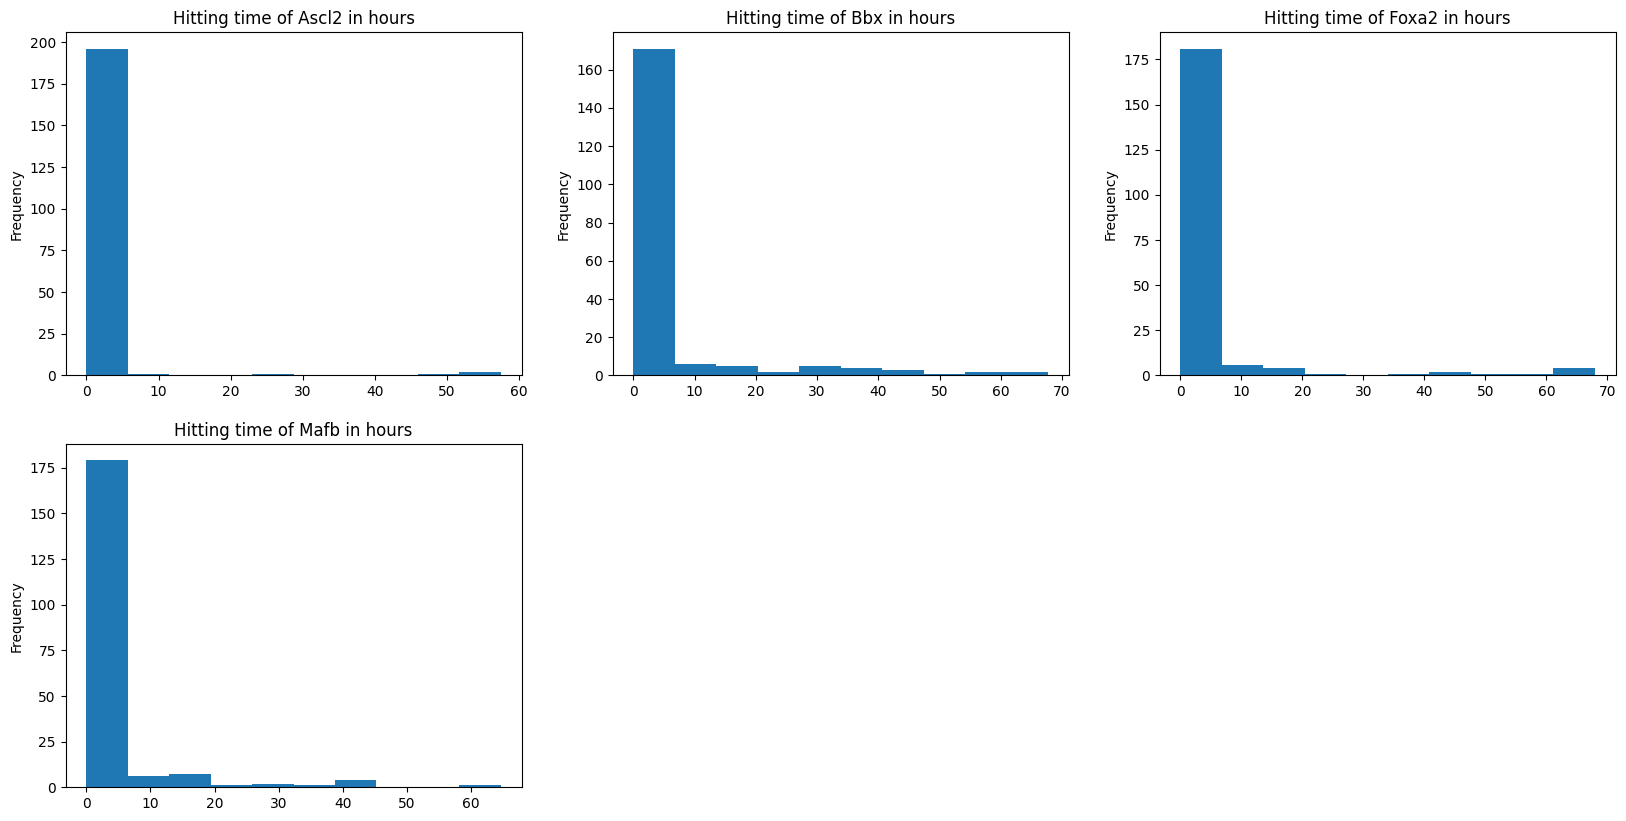

In [ ]:
plt.figure(figsize=(20,10), dpi=100)

for i, phen in enumerate(phenotypes):
  plt.subplot(2,3,i+1)
  plt.title("Hitting time of " + phen +" in hours")
  (simulations_results['tau_'+phen]/(3600)).plot(kind="hist")

plt.show()

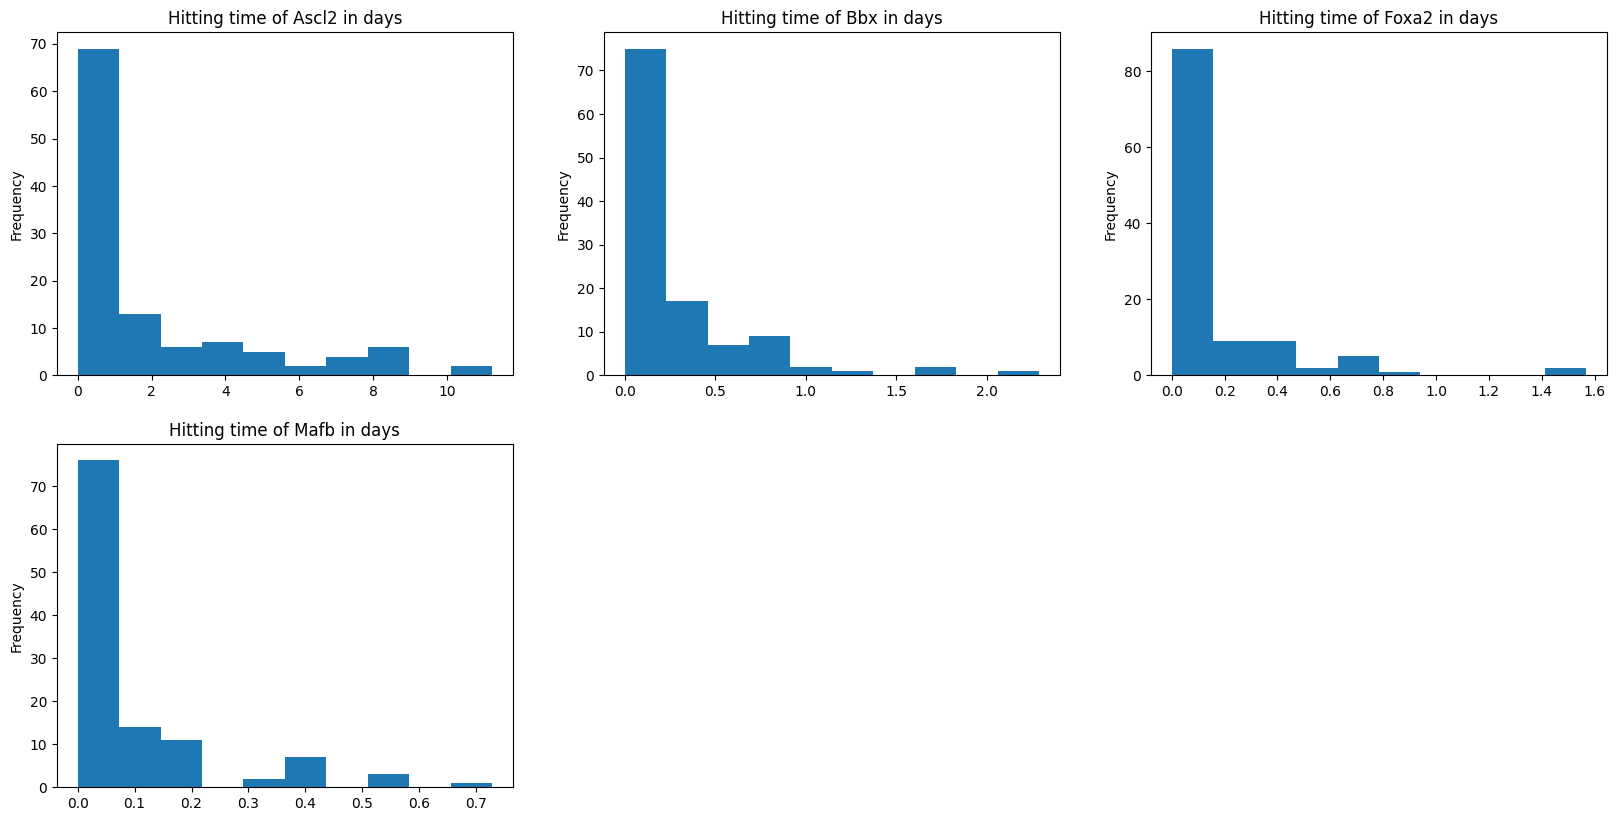

In [ ]:
plt.figure(figsize=(20,10), dpi=100)

for i, phen in enumerate(phenotypes):
  plt.subplot(2,3,i+1)
  plt.title("Hitting time of " + phen+" in days")
  (simulations_results_c['tau_'+phen]/(3600*24)).plot(kind="hist")

plt.show()

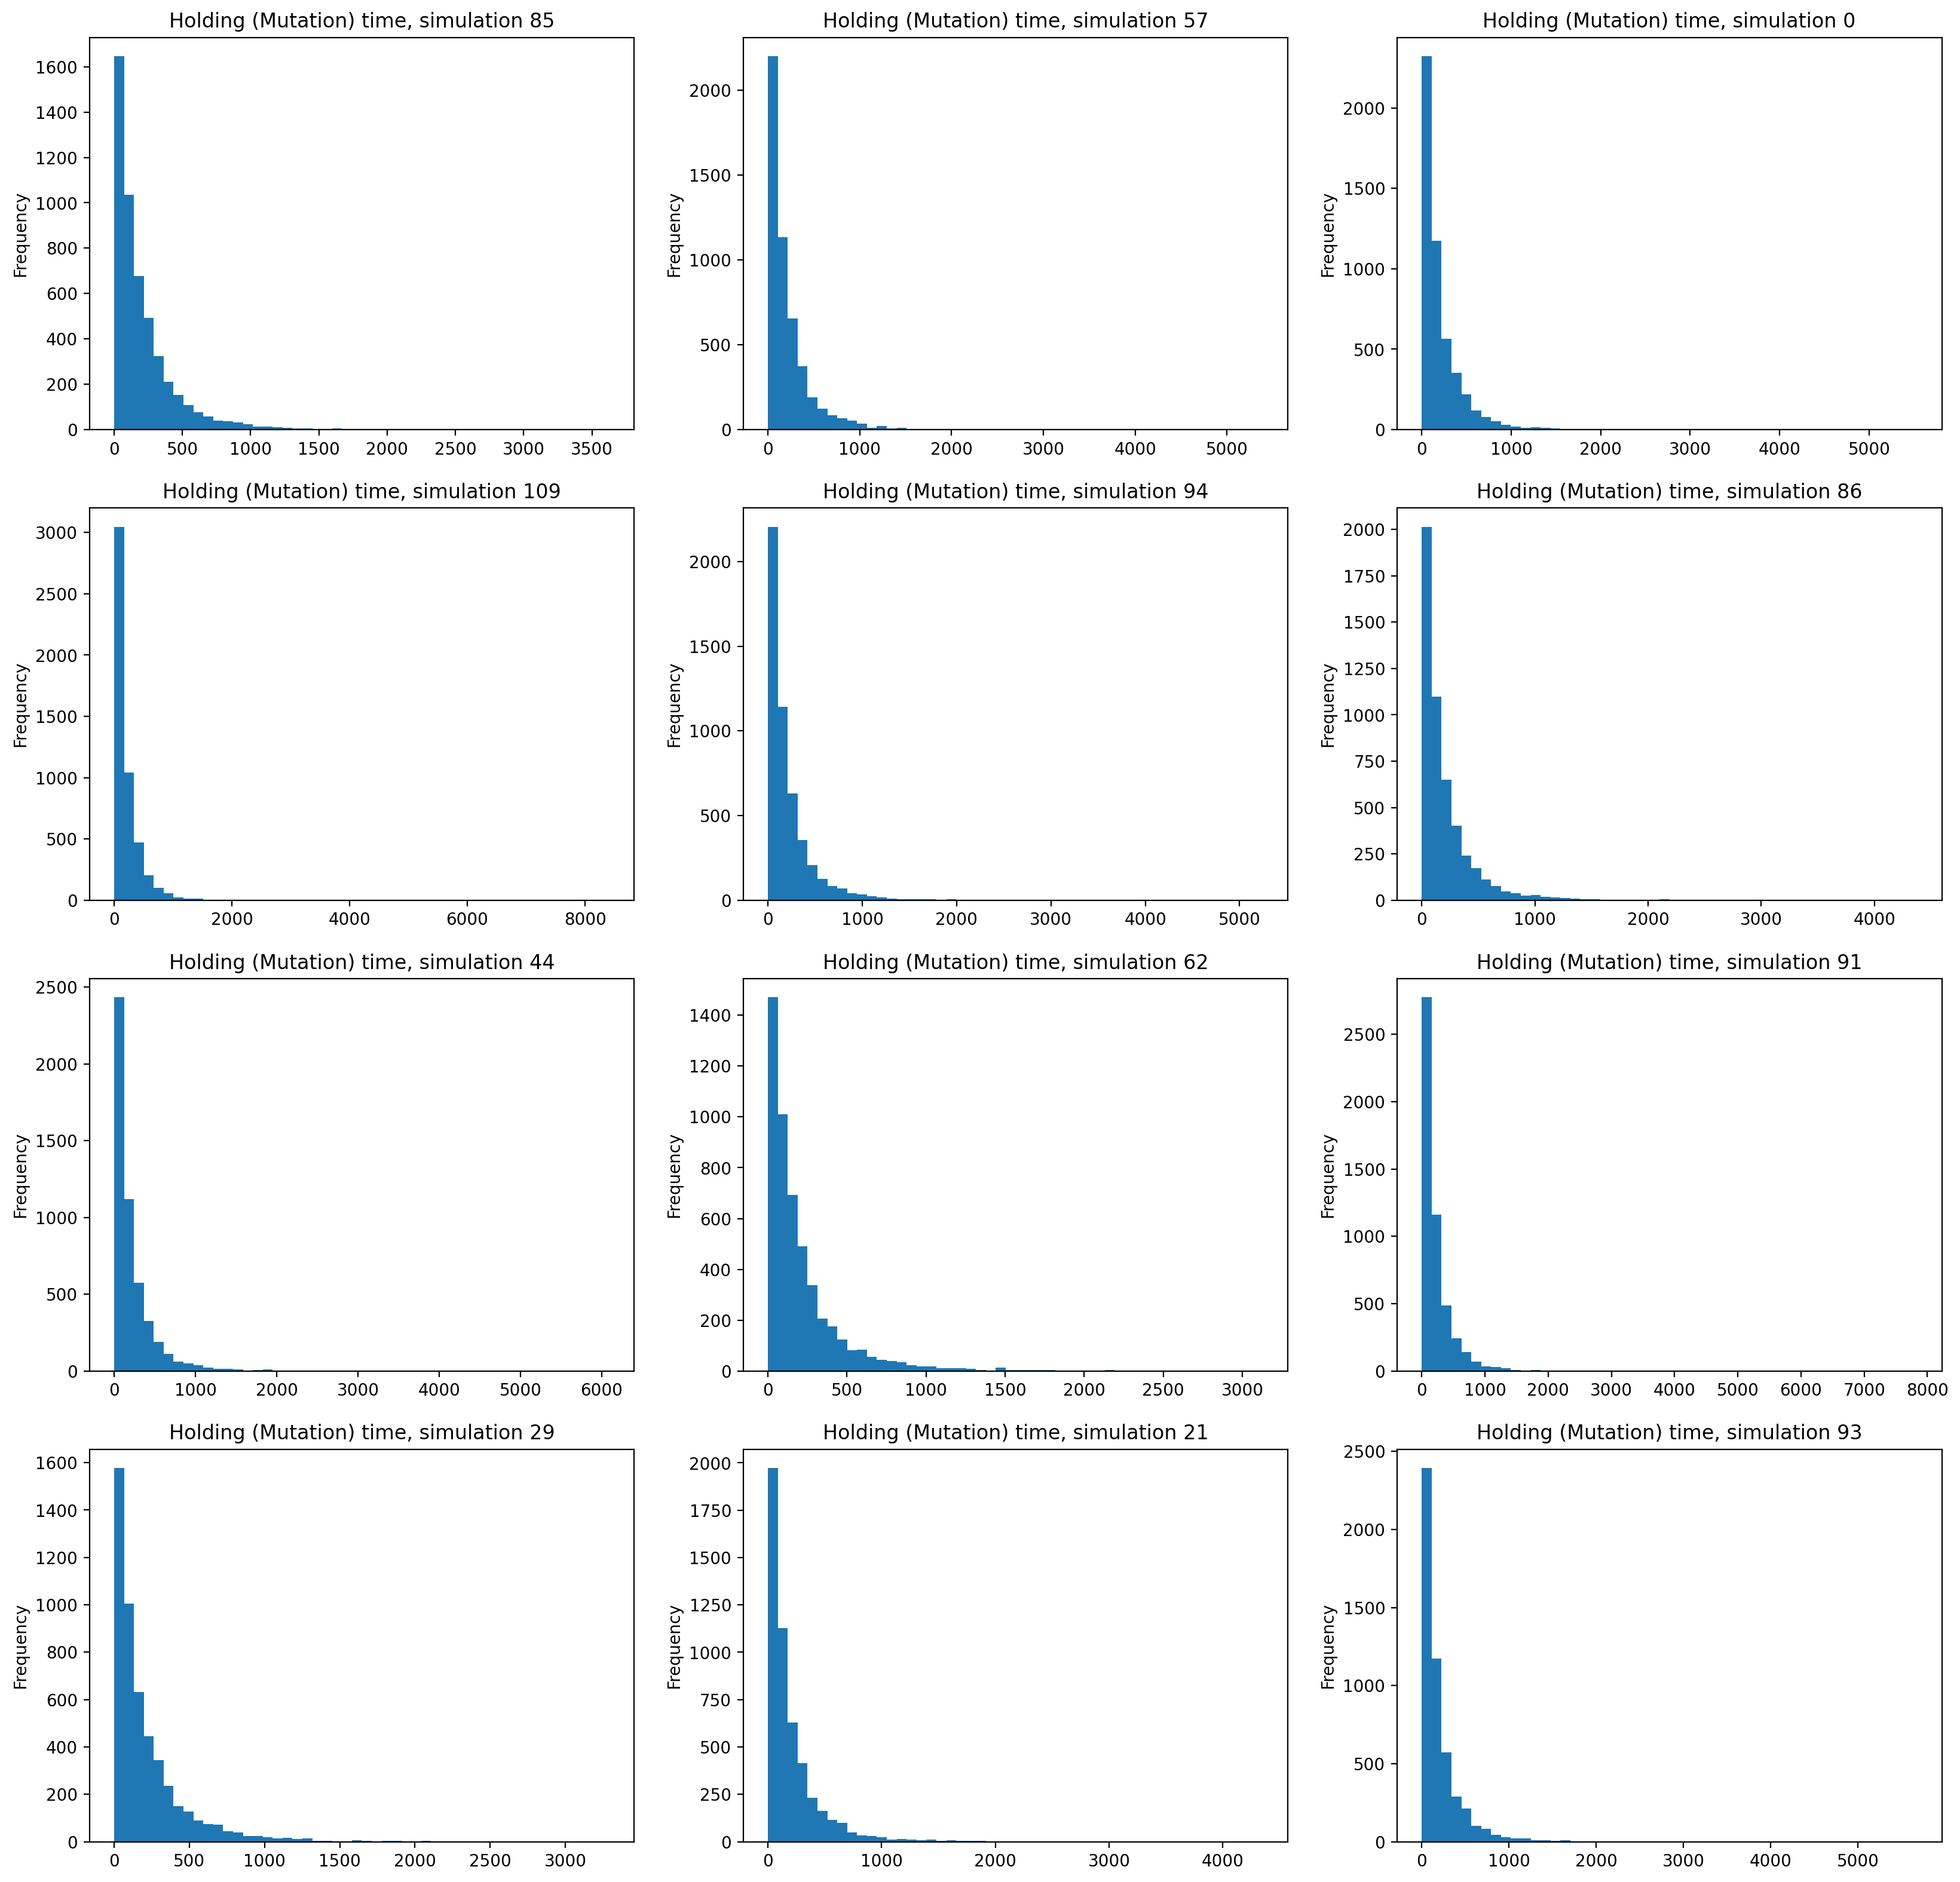

In [ ]:
plt.figure(figsize=(20,20), dpi=200)
np.random.seed(2021)

for i in range(12):
  simulation_index = np.random.choice(list(all_evolution_paths_c.keys()))
  plt.subplot(4,3,i+1)
  plt.title("Holding (Mutation) time, simulation "+str(simulation_index))
  all_evolution_paths_c[simulation_index]['holding time'].plot(kind="hist", bins=50)

plt.show()

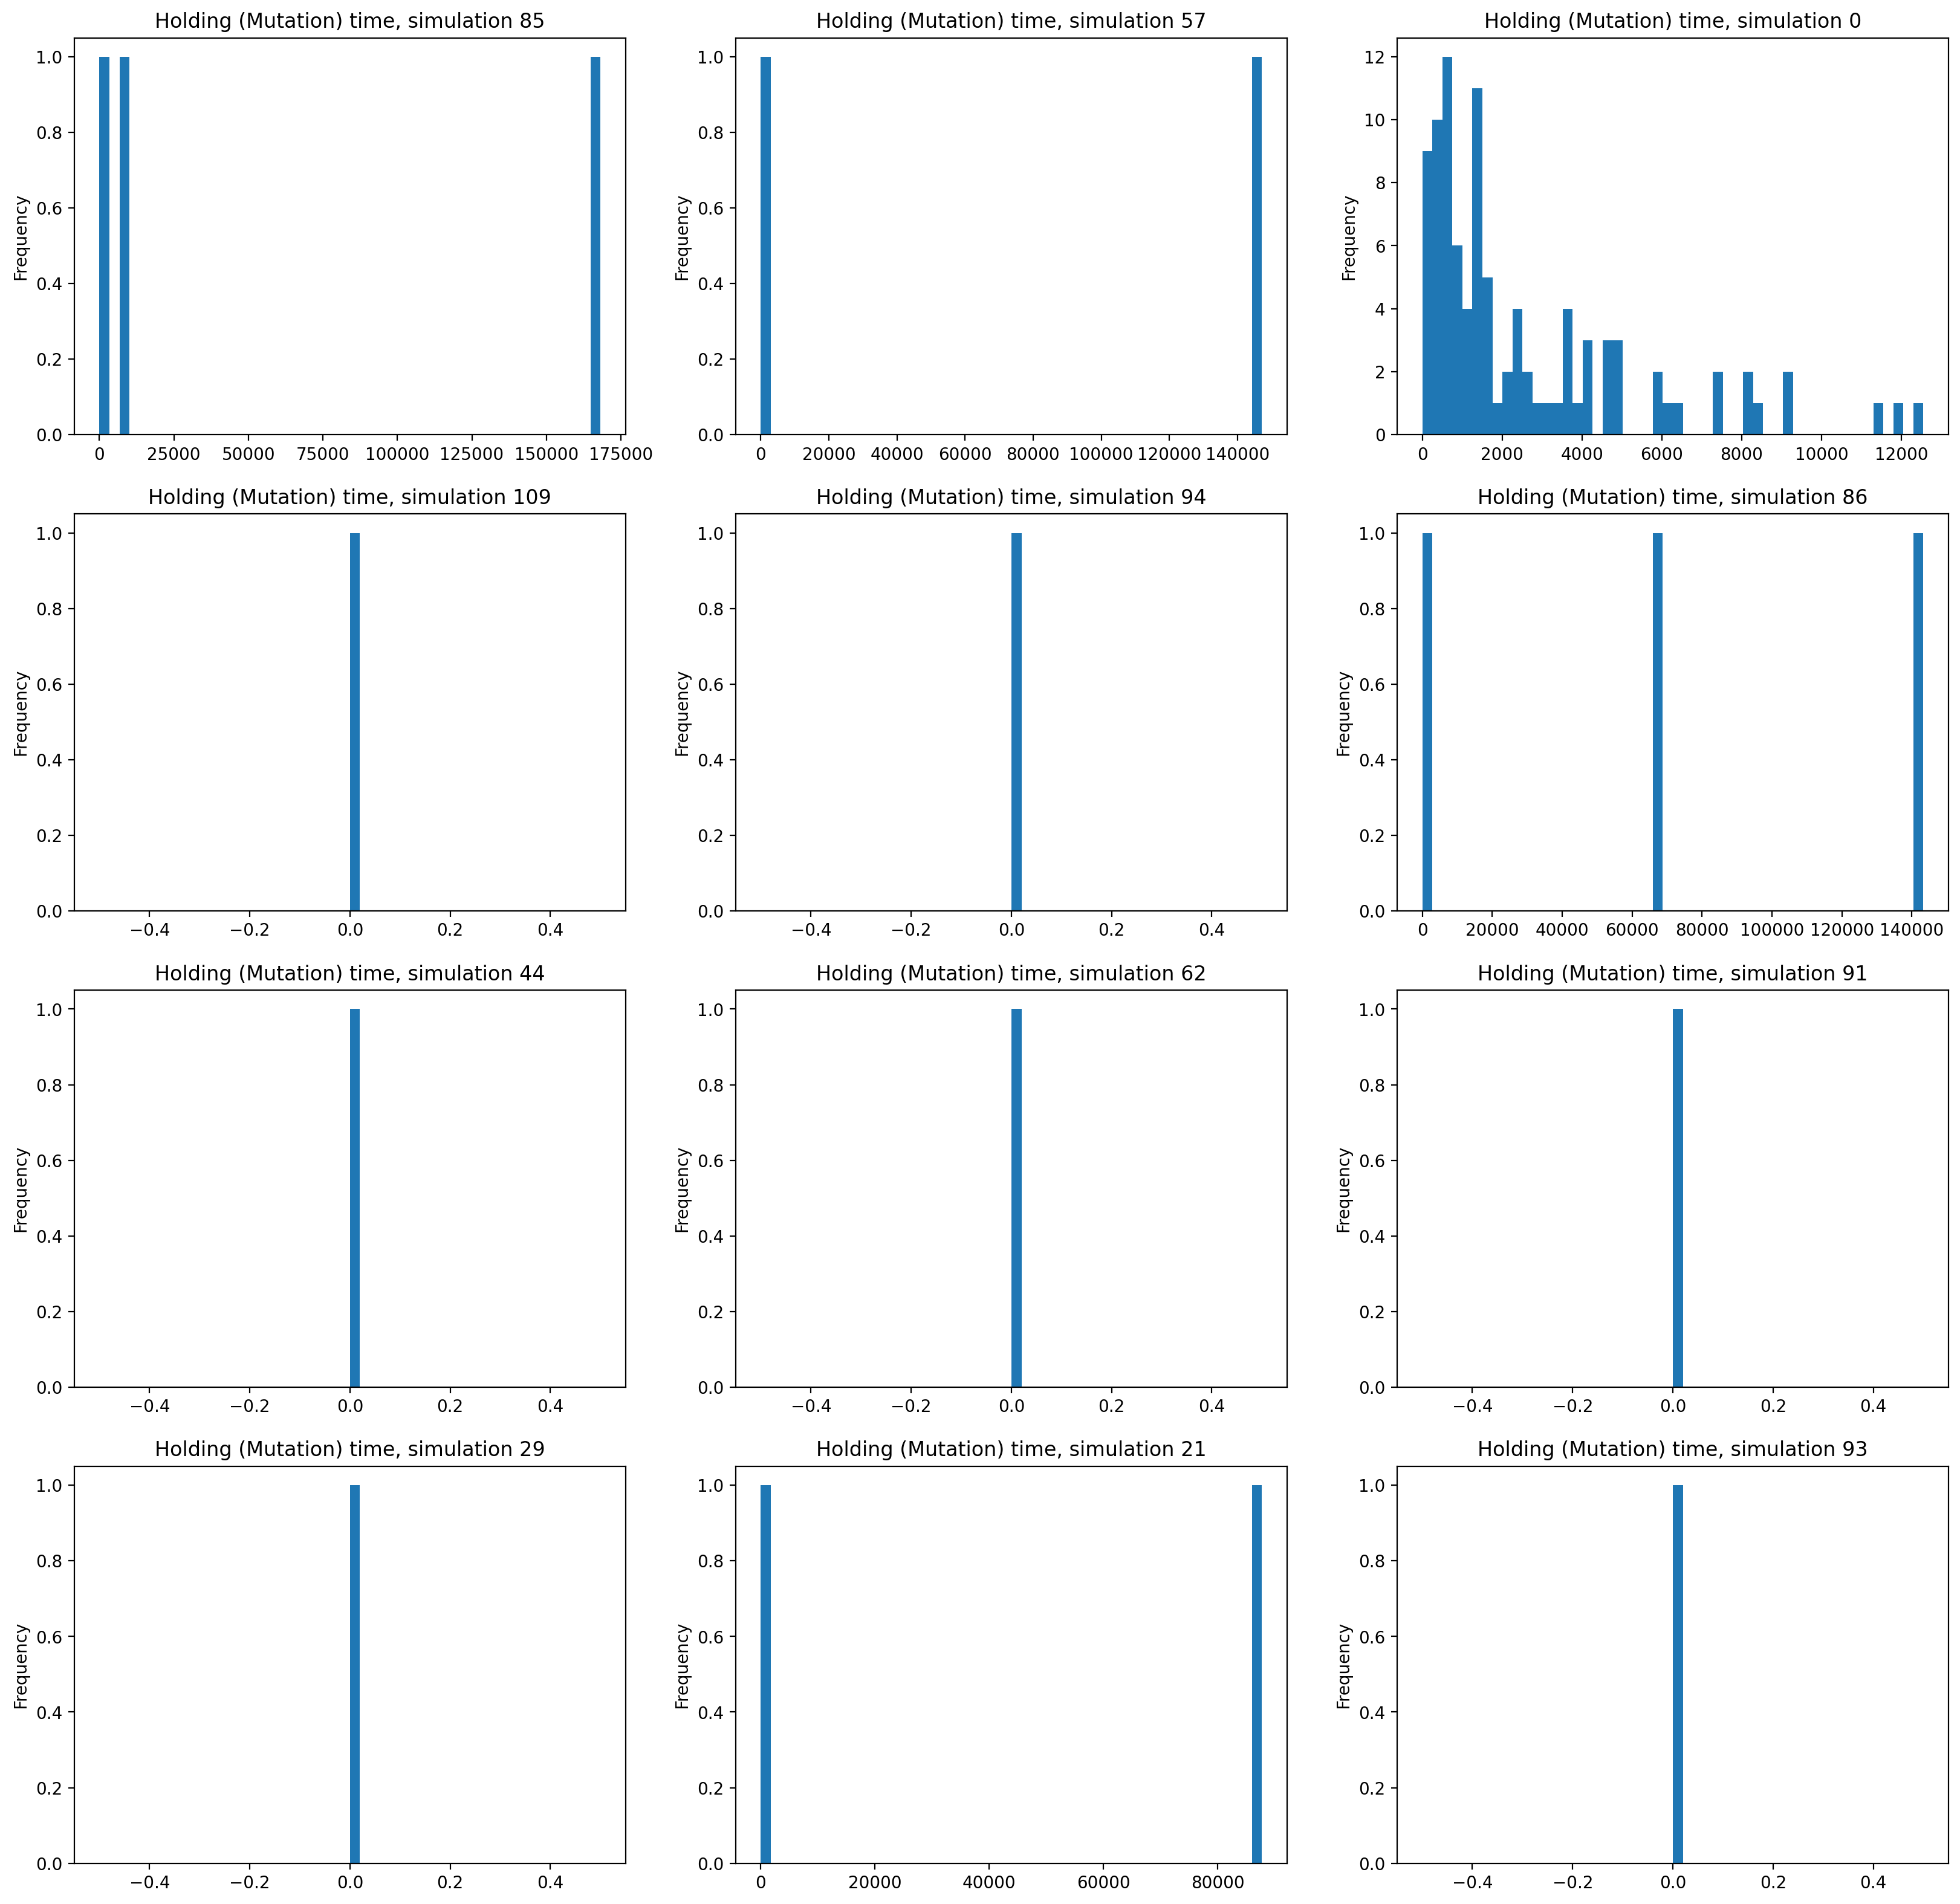

In [ ]:
plt.figure(figsize=(20,20), dpi=200)
np.random.seed(2021)

for i in range(12):
  simulation_index = np.random.choice(list(all_evolution_paths_c.keys()))
  plt.subplot(4,3,i+1)
  plt.title("Holding (Mutation) time, simulation "+str(simulation_index))
  all_evolution_paths_mutations[simulation_index]['mutation time'].plot(kind="hist", bins=50)

plt.show()

In [ ]:
bins = [-2, -0.5, 100, 500]  # The edges
for i in range(1000,3000, 500):
  bins.append(i)

groups = pd.cut(all_evolution_paths_mutations[0]['holding time'], bins=bins)

groups.value_counts()

(100.0, 500.0]      64
(-0.5, 100.0]       33
(2000.0, 2500.0]     0
(1500.0, 2000.0]     0
(1000.0, 1500.0]     0
(500.0, 1000.0]      0
(-2.0, -0.5]         0
Name: holding time, dtype: int64

In [ ]:
all_evolution_paths_mutations[62]

,holding time,accumulated time,genotype index,genotype sequence,Ascl2 freq.,Bbx freq.,Foxa2 freq.,Mafb freq.,mutation time
0,0.0,0.0,552,ATGAAAAA,0.0,0.0,0.0,1.0,0


### Plotting categorical data with Seaborn ([click here](https://seaborn.pydata.org/tutorial/categorical.html))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

In [ ]:
simulations = 40 # number of of last simulations to compare
phenotypes = genotype_networks_4phen.keys()

In [ ]:
simulations_results

,parameters_index,tau_Ascl2,tau_Bbx,tau_Foxa2,tau_Mafb,N_Ascl2,N_Bbx,N_Foxa2,N_Mafb
0,0.0,-1.000000,-1.000000,48201.618690,0.000000,-1.0,-1.0,983.0,0.0
1,0.0,-1.000000,131112.550087,23713.601659,0.000000,-1.0,2621.0,445.0,0.0
2,0.0,-1.000000,201750.675204,3703.249948,0.000000,-1.0,4041.0,69.0,0.0
3,0.0,-1.000000,141926.249905,22674.404962,0.000000,-1.0,2769.0,437.0,0.0
4,0.0,-1.000000,164332.314996,25337.977626,0.000000,-1.0,3349.0,504.0,0.0
...,...,...,...,...,...,...,...,...,...
196,81.0,0.000000,243693.624261,243146.910956,232750.934378,0.0,4860.0,4849.0,4658.0
197,82.0,-1.000000,105173.301284,0.000000,2440.516368,-1.0,2059.0,0.0,54.0
198,83.0,206848.934784,-1.000000,0.000000,141660.516225,4161.0,-1.0,0.0,2882.0
199,84.0,-1.000000,-1.000000,204233.061299,0.000000,-1.0,-1.0,4117.0,0.0


In [ ]:
simulations_index[-1-1]

199

In [ ]:
results = pd.DataFrame(columns=['simulation index', 'final phenotype', 'initial phenotype', 'hitting time'])
simulations_index = list(simulations_results.index)

for i in range(simulations):
  for phen in phenotypes:
    hitting_time_phen = simulations_results['tau_'+phen][simulations_index[-1-i]]

    if hitting_time_phen > 0.0:
      results_aux = {'simulation index': simulations_index[-1-i], 'final phenotype': phen, 
        'initial phenotype': parameters['initial_phen'][simulations_results['parameters_index'][simulations_index[-1-i]]],
        'hitting time': hitting_time_phen/(3600*24)}

      results = results.append(results_aux, ignore_index=True)


In [ ]:
results_c = pd.DataFrame(columns=['simulation', 'final phenotype', 'initial phenotype', 'hitting time'])
simulations_index_c = list(simulations_results_c.index)

for i in range(simulations):
  for phen in phenotypes:
    hitting_time_phen = simulations_results_c['tau_'+phen][simulations_index_c[-1-i]]

    if hitting_time_phen > 0.0:
      results_aux = {'simulation index': simulations_index_c[-1-i], 'final phenotype': phen, 
        'initial phenotype': parameters_c['initial_phen'][simulations_results_c['parameters_index'][simulations_index_c[-1-i]]],
        'hitting time': hitting_time_phen/(3600*24)}

      results_c = results_c.append(results_aux, ignore_index=True)

Graph Hitting time vs final phenotype. Each dot is a random simulation which has hitting times to novel phenotypes. The graph shows the kernel density estimation of the hitting times to a given final phenotype and the scatter plot.

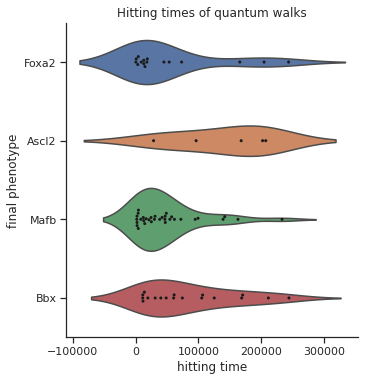

In [ ]:
g = sns.catplot(x="hitting time", y="final phenotype", kind="violin", inner=None, data=results)
g.set(title="Hitting times of quantum walks")
sns.swarmplot(x="hitting time", y="final phenotype", color="k", size=3, data=results, ax=g.ax)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 32.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


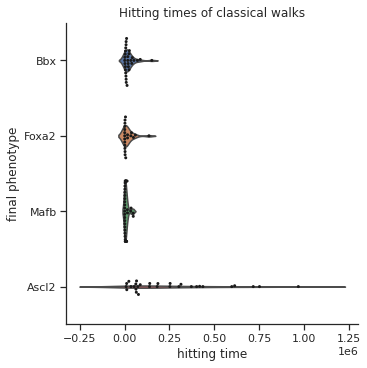

In [ ]:
g2 = sns.catplot(x="hitting time", y="final phenotype", kind="violin", inner=None, data=results_c)
g2.set(title="Hitting times of classical walks")
sns.swarmplot(x="hitting time", y="final phenotype", color="k", size=3, data=results_c, ax=g2.ax)

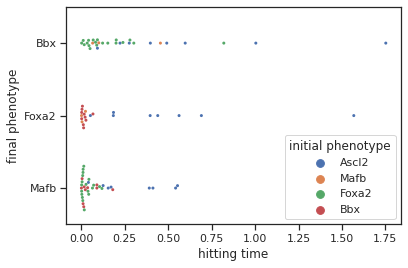

In [ ]:
sns.swarmplot(x="hitting time", y="final phenotype", hue='initial phenotype', size=3, data=results_c[results_c['final phenotype']!='Ascl2'])

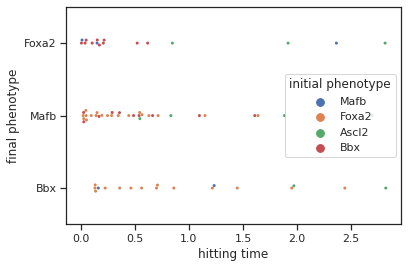

In [ ]:
sns.swarmplot(x="hitting time", y="final phenotype", hue='initial phenotype', size=3, data=results[results['final phenotype']!='Ascl2'])

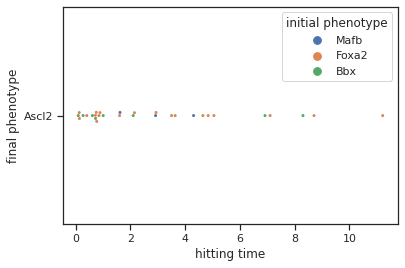

In [ ]:
sns.swarmplot(x="hitting time", y="final phenotype", hue='initial phenotype', size=3, data=results_c[results_c['final phenotype']=='Ascl2'])

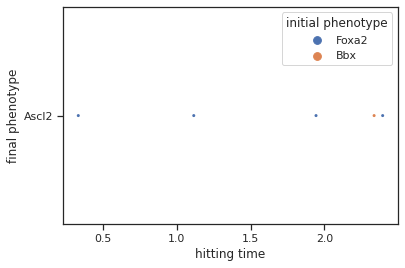

In [ ]:
sns.swarmplot(x="hitting time", y="final phenotype", hue='initial phenotype', size=3, data=results[results['final phenotype']=='Ascl2'])

## Other

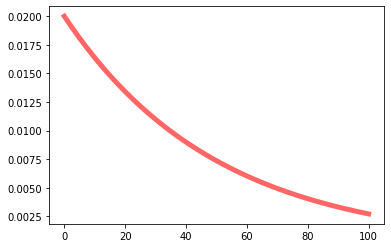

In [ ]:
from scipy.stats import expon

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

x = np.linspace(0,100, 1000)

ax.plot(x, expon.pdf(x, scale=50), 'r-', lw=5, alpha=0.6, label='expon pdf')